# Perception multicamadas(MLP) com a base de dados MNIST

## Objetivos e Métodos

Utilizar a base de dados MNIST, para deselvolver uma rede neural MLP que seja capaz de identificar numeros manuscritas com uma boa acuracia

## 1 DEFINIÇÕES

### 1.1 Módulos Necessários

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### 1.2 Importando a base de dados e definindo o tamanho dos minibatch

In [2]:
class MNIST(d2l.DataModule): #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()

data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


### 1.3 Lendo o minibatch

In [3]:
@d2l.add_to_class(MNIST) #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
        tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(
        self.batch_size).shuffle(shuffle_buf)

X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


## 2 Treinamento

### 2.1 Modelo MLP (Implemetação Concisa)

#### 2.1 a) Perceptron com uma camada escondida, função de ativação sigmoide, função custo SSE e otimização por descida de gradiente.

In [21]:
class MLP(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = tf.keras.models.Sequential([
				tf.keras.layers.Flatten(),
				tf.keras.layers.Dense(num_hiddens, activation='sigmoid'), #SIGMOID
				tf.keras.layers.Dense(num_outputs)])
    self.loss_fn = tf.keras.losses.MeanSquaredError()     # Configurando o erro quadrático médio como função de custo
    self.optimizer = tf.keras.optimizers.SGD(lr)          # Configurando a descida de gradiente (SGD) como otimizador


ACURACIA MEDIA DOS 3 TREINAMENTOS = 96.0 %


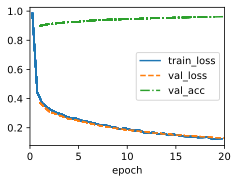

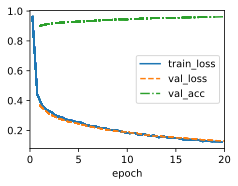

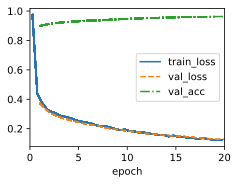

In [6]:
n_train = 3                                                               #Número de treinamentos objetivados
test_acc =[]                                                              #Instância uma lista para armazenar a acurácia de cada treino

for i in range(n_train):
  model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)                    #10 classes de saída, 128 neurônios na camada escondida, taxa de aprendizado
  data = MNIST(batch_size=64)                                             #Passa os dados para o formato correto para o treinamento, define os minibatchs (64)
  trainer = d2l.Trainer(max_epochs=20)                                    #Define o objeto trainer com a quantidade de épocas (10)
  trainer.fit(model, data)                                                #Realiza o treinamento
  test_acc.append(d2l.evaluate_accuracy(model, data.val_dataloader()))    #Avalia a acurácia comparando os dados de validação com o modelo e guarda o valor na lista de acurácias

#Imprime a média das acurácias dos n treinamentos
print(f"""\nACURACIA MEDIA DOS {n_train} TREINAMENTOS = {tf.round(tf.reduce_mean(test_acc)*100,3)} %""")

Observando o Perceptron clássico, é perceptível que ocorre uma queda brusca no erro de treinamento nas épocas iniciais, como esperado, já que estamos utilizando a função de custo e o erro quadrático que estamos tentando minimizar. Essa abordagem, em termos de função de custo e função de ativação, é a mesma usada na regressão linear. No entanto, torna-se evidente que não estamos aproveitando as vantagens de estarmos lidando com um problema de classificação. Porém, a alta eficiência da Rede Neural Multilayer Perceptron (MLP) permite alcançar uma alta acurácia, o que indica que estamos trabalhando com um bom modelo



#### 2.1 b) Perceptron com uma camada escondida com função de ativação softmax na ultima camada, função custo entropia cruzada e otimização por descida de gradiente(Mesma do anterior).

In [18]:
class MLP(d2l.Classifier):
	def __init__(self, num_outputs, num_hiddens, lr):
		super().__init__()
		self.save_hyperparameters()
		self.net = tf.keras.models.Sequential([
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(num_hiddens, activation='sigmoid'), 		#Camada escondida com SIGMOID
			tf.keras.layers.Dense(num_outputs,activation='softmax')]) 		#Última camada com softmax

		self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()	#Configura a entropia cruzada como função de custo
		self.optimizer = tf.keras.optimizers.SGD(lr)                  	#SGD como otimizador


ACURACIA MEDIA DOS 5 TREINAMENTOS = 86.0 %


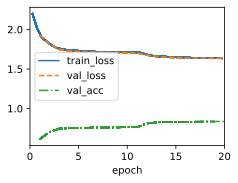

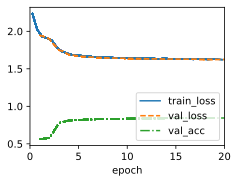

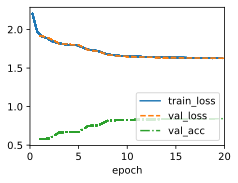

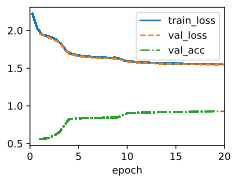

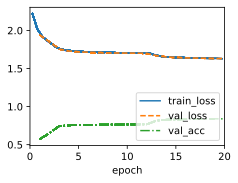

In [19]:
n_train = 5                                                               #Número de treinamentos objetivados
test_acc =[]                                                              #Instância uma lista para armazenar a acurácia de cada treino

for i in range(n_train):
  model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)                    #10 classes de saída, 128 neurônios na camada escondida, taxa de aprendizado
  data = MNIST(batch_size=64)                                             #Passa os dados para o formato correto para o treinamento, define os minibatchs (64)
  trainer = d2l.Trainer(max_epochs=20)                                    #Define o objeto trainer com a quantidade de épocas (10)
  trainer.fit(model, data)                                                #Realiza o treinamento
  test_acc.append(d2l.evaluate_accuracy(model, data.val_dataloader()))    #Avalia a acurácia comparando os dados de validação com o modelo e guardando o valor na lista de acurácias

#Imprime a média das acurácias dos n treinamentos
print(f"""\nACURACIA MEDIA DOS {n_train} TREINAMENTOS = {tf.round(tf.reduce_mean(test_acc)*100,3)} %""")

Embora tenhamos feito melhorias em nosso sistema, utilizando uma função de ativação (softmax) e uma função de custo (Entropia Cruzada) mais eficientes para lidar com a classificação one-hot, observamos uma queda na acurácia. Isso ocorre porque a camada oculta possui uma função de ativação sigmoid, que pode causar problemas de saturação e gradiente desvanecido, tornando a aprendizagem mais difícil. Além disso, a função sigmoid na camada oculta não é compatível com a função softmax na saída, pois ela não preserva a relação entre as classes, diminuindo a confiança na predição. Uma solução possível para esse problema é usar uma função de ativação diferente na camada oculta, como a ReLU(que sera usada a frente), que não tem limite superior e é mais adequada para trabalhar com a função softmax na saída.

#### 2.1 c) Mudando o otmizador por decidade de gradiente para o  Otimizador Adam, capcidade de modificar "lr" (taxa de aprendizado) durante o treinamento

In [9]:
class MLP(d2l.Classifier):
	def __init__(self, num_outputs, num_hiddens, lr):
		super().__init__()
		self.save_hyperparameters()
		self.net = tf.keras.models.Sequential([
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(num_hiddens, activation='sigmoid'), 		#SIGMOID
			tf.keras.layers.Dense(num_outputs,activation='softmax')]) 		#Softmax

		self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()	#Configura a entropia cruzada como função de custo
		self.optimizer = tf.keras.optimizers.Adam()                   	#Configura a descida de gradiente (SGD) como otimizador


ACURACIA MEDIA DOS 5 TREINAMENTOS = 79.0 %


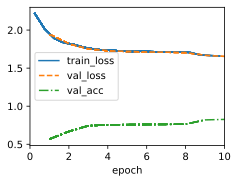

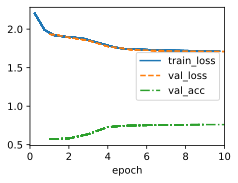

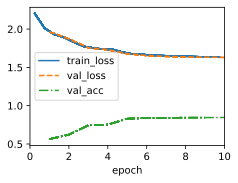

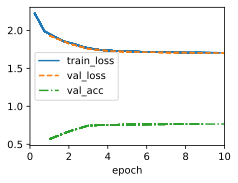

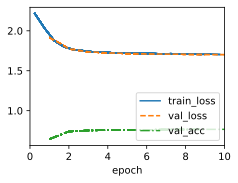

In [10]:
n_train = 5                                                               #Número de treinamentos objetivados
test_acc =[]                                                              #Instância uma lista para armazenar a acurácia de cada treino

for i in range(n_train):
  model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)                    #10 classes de saida, 128 neurônios na camada escondida, taxa de aprendizado
  data = MNIST(batch_size=64)                                             #Passa os dados para o formato correto para o treinamento, define os minibatchs (64)
  trainer = d2l.Trainer(max_epochs=10)                                    #Define o objeto trainer com a quantidade de épocas (10)
  trainer.fit(model, data)                                                #Realiza o treinamento
  test_acc.append(d2l.evaluate_accuracy(model, data.val_dataloader()))    #Avalia a acurácia comparando os dados de validação com o modelo e guardando o valor na lista de acurácias

#Imprime a média das acurácias dos n treinamentos
print(f"""\nACURACIA MEDIA DOS {n_train} TREINAMENTOS = {tf.round(tf.reduce_mean(test_acc)*100,3)} %""")

Outra melhoria proposta é a troca do otimizador para o Adam, o que aprimora nosso modelo, uma vez que resolve o problema da taxa de aprendizado. Anteriormente, a taxa de aprendizado era determinada empiricamente e mantida constante durante todo o treinamento, o que apresenta desvantagens. Uma taxa de aprendizado maior acelera a descida do gradiente, mas pode ser problemática se for muito grande, pois esse aumento de velocidade pode levar à divergência do sistema, fazendo com que os parâmetros cresçam indefinidamente. No entanto, com a mudança dinâmica da taxa de aprendizado fornecida pelo otimizador Adam, observamos uma melhoria em relação ao caso anterior. Embora a acurácia do modelo inicial (2.1 - a) ainda não tenha sido alcançada, isso se deve ao problema do modelo anterior, que envolve o uso da função softmax após uma função sigmoide na camada oculta, que permanece

#### 2.1 d) Substituindo a função de ativação da camada oculta de sigmoide para ReLu

In [11]:
class MLP(d2l.Classifier):
	def __init__(self, num_outputs, num_hiddens, lr):
		super().__init__()
		self.save_hyperparameters()
		self.net = tf.keras.models.Sequential([
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(num_hiddens, activation='relu'),      	#ReLu
			tf.keras.layers.Dense(num_outputs,activation='softmax')])   	#Softmax

		self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()  #Seta a entropia cruzada como função de custo
		self.optimizer = tf.keras.optimizers.Adam()                     #Seta a descida de gradiente (SGD) como otimizador


ACURACIA MEDIA DOS 5 TREINAMENTOS = 94.0 %


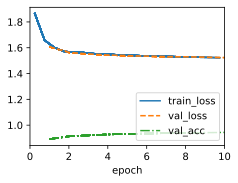

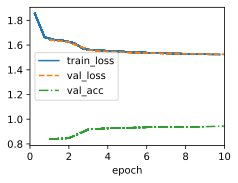

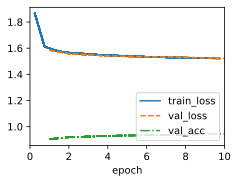

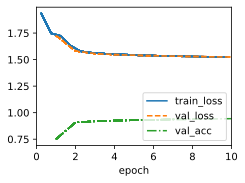

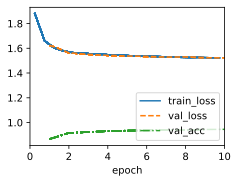

In [12]:
n_train = 5                                                               #Número de treinamentos objetivados
test_acc =[]                                                              #Instância uma lista para armazenar a acurácia de cada treino

for i in range(n_train):
  model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)                    #10 classes de saída, 128 neurônios na camada escondida, taxa de aprendizado
  data = MNIST(batch_size=64)                                             #Passa os dados para o formato correto para o treinamento, define os minibatchs (64)
  trainer = d2l.Trainer(max_epochs=10)                                    #Define o objeto trainer com a quantidade de épocas (10)
  trainer.fit(model, data)                                                #Realiza o treinamento
  test_acc.append(d2l.evaluate_accuracy(model, data.val_dataloader()))    #Avalia a acurácia comparando os dados de validação com o modelo e guardando o valor na lista de acurácias

#Imprime a média das acurácias dos n treinamentos
print(f"""\nACURACIA MEDIA DOS {n_train} TREINAMENTOS = {tf.round(tf.reduce_mean(test_acc)*100,3)} %""")

A troca da função de ativação sigmoide pela função ReLU resultou em uma melhoria significativa no desempenho do modelo. Isso se deve em grande parte à natureza das duas funções de ativação. A função sigmoide gera saídas contínuas no intervalo de 0 a 1, o que pode causar o problema do gradiente desvanecido em redes neurais profundas. Em contraste, a função ReLU gera saídas no intervalo $[0, \infty)$, o que evita o problema do gradiente desvanecido, permitindo que o modelo aprenda de maneira mais eficaz.

Além disso, a função ReLU introduz não linearidade de forma mais eficaz, o que é fundamental para a capacidade de aprendizado da rede. Isso significa que a rede é capaz de representar relações complexas nos dados de treinamento. Portanto, a combinação da função ReLU na camada oculta com a função softmax na camada de saída resulta em uma melhoria geral na capacidade do modelo de representar e classificar com precisão as classes do conjunto de dados MNIST.

#### 2.1 e) Rede Maior, 2 camadas escondidas com 256 neuronios cada

In [13]:
class MLP(d2l.Classifier):
	def __init__(self, num_outputs, num_hiddens, lr):
		super().__init__()
		self.save_hyperparameters()
		self.net = tf.keras.models.Sequential([
			tf.keras.layers.Flatten(),
			tf.keras.layers.Dense(num_hiddens, activation='relu'),      	#Camada Escondida 1 (função de ativação relu)
			tf.keras.layers.Dense(num_hiddens, activation='relu'),      	#Camada Escondida 2 (função de ativação relu)
			tf.keras.layers.Dense(num_outputs,activation='softmax')])   	#Softmax

		self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()  #Seta a entropia cruzada como função de custo
		self.optimizer = tf.keras.optimizers.Adam()                     #Seta a descida de gradiente (SGD) como otimizador


ACURACIA MEDIA DOS 5 TREINAMENTOS = 97.0 %


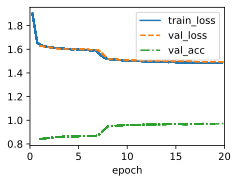

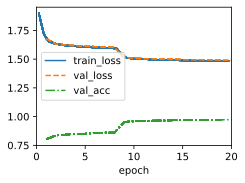

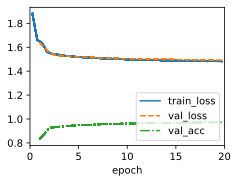

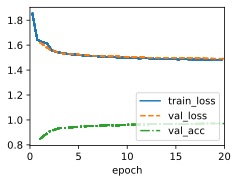

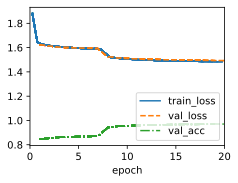

In [14]:
n_train = 5                                                               #Número de treinamentos objetivados
test_acc =[]                                                              #Instância uma lista para armazenar a acurácia de cada treino

for i in range(n_train):
  model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)                    #10 classes de saída, 256 neurônios na camada escondida, taxa de aprendizado
  data = MNIST(batch_size=64)                                             #Passa os dados para o formato correto para o treinamento, define os minibatchs (64)
  trainer = d2l.Trainer(max_epochs=20)                                    #Define o objeto trainer com a quantidade de épocas (10)
  trainer.fit(model, data)                                                #Realiza o treinamento
  test_acc.append(d2l.evaluate_accuracy(model, data.val_dataloader()))    #Avalia a acurácia comparando os dados de validação com o modelo e guardando o valor na lista de acurácias

#Imprime a média das acurácias dos n treinamentos
print(f"""\nACURACIA MEDIA DOS {n_train} TREINAMENTOS = {tf.round(tf.reduce_mean(test_acc)*100,3)} %""")

Por fim chegamos ao modelo com os melhores resultados entre os propostos. Com a adição da segunda camada ativa e do dobro de neurônios chegamos a acurácia de 97%

# 3 - Vizualizados erros na classificação

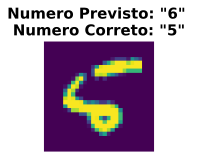

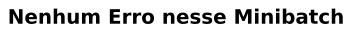

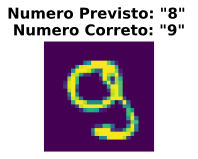

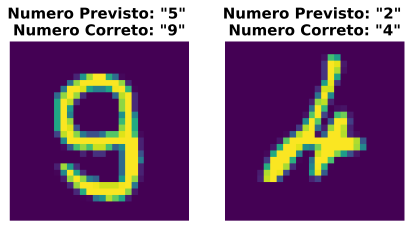

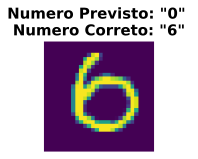

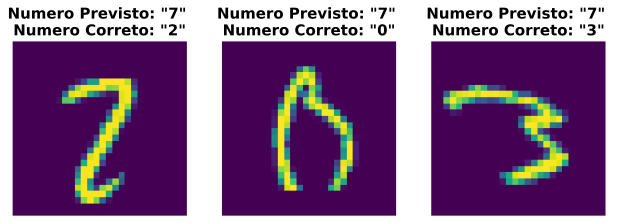

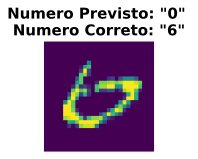

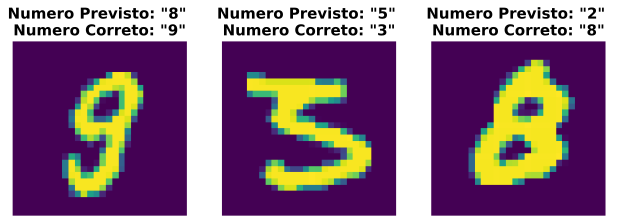

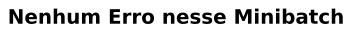

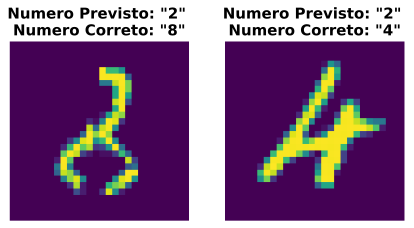

In [15]:
n_batches = 10                                        	#Numero de batches que objetivamos testar

batch_n = 0                                            	#Minebatch atual
for X,y in data.val_dataloader():                       #Percorrendo os Minibatches da Validação
	preds=tf.argmax(model(X),axis=1)                    	#Obtendo a previsão do modelo paras as entrada , já que a última camada é softmax escolhe-se o termo com maior probabilidade

	#Usando o método do exemplo pronto para imprimir erros :
	wrong=tf.cast(preds,y.dtype)!=y                     	#Compara se a categoria prevista para a entrada e diferente da correta da saida (y nesse caso o número), retorna uma máscara com os batchs que são diferentes como true
	X,y,preds=X[wrong],y[wrong],preds[wrong]            	#Obtém-se a entrada equivalente aos termos classificados errados, obtém-se as cotegorias corretas dos itens errados, obtém-se quais foram as previsões erradas
	labels=[f'Numero Previsto: "{a}" \nNumero Correto: "{b}"' for a,b in zip(preds,y)] #Define os rótulos (numeros previstos por nosso modelo, números corretos guardados em "y")
	n_erros = X.shape[0]                                 	#Número de erros na previsão

	#-------------------------------- PLOTANDO --------------------------------

	if n_erros != 0:            													#Solução simples par plotar somente caso houver algum erro no mini batcher
		fig = plt.figure(figsize=(n_erros*2,n_erros*2))  		#Tamanho da figura
		if n_erros > 1: axs = fig.subplots(1, n_erros)
		else: axs = [fig.add_subplot(111)]

		#Plotando lado a lado os erro do minebatch, defindo detalhes de estilo
		for col in range(n_erros):
				axs[col].imshow(X[col])
				axs[col].set_title(labels[col],fontweight="bold",fontsize = 15)
				axs[col].axis('off')
		plt.subplots_adjust(bottom=None,top=None,right=1.5,left=None,wspace=None,hspace=None) #Ajusta distancia dos subplotas
		plt.show()

	#Caso não haja erros nesse minebatch imprime a caixa de texto:
	else:
		fig = plt.figure(figsize=(0.3,0.3))
		plt.text(0,0,"Nenhum erro nesse Minibatch",fontweight="bold", fontsize=20)
		plt.axis('off')
	plt.show()

	batch_n += 1
	if(batch_n ==n_batches): break

É perceptível que, embora nosso modelo cometa erros em alguns casos aparentemente óbvios, na grande maioria dos casos os erros são completamente plausíveis, como números com escrita próxima ou erros de grafia presentes na própria base de dados, tornando a identificação difícil até mesmo para um ser humano, o que demonstra a robustez de nosso sistema.

# 4. Matriz de confusão

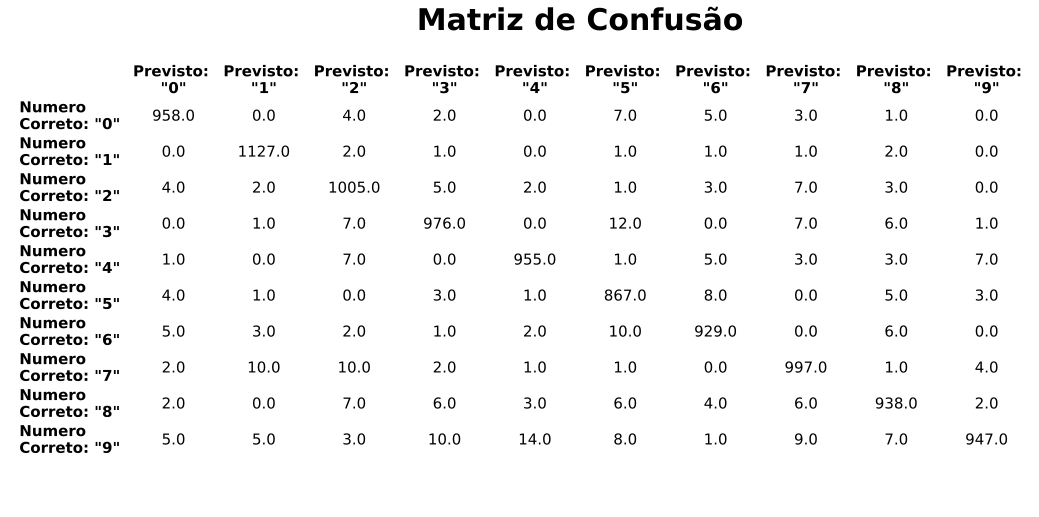

In [16]:
_,y = next(iter(data.val_dataloader()))                                 #Obtém-se as saídas de um minibatch
num_classes = tf.size((tf.unique(y)[0]))                                #Encontra os números de termos únicos da saída (separando as classes), o tamanho desse tensor dá o numero de classes
combined_confusion_matrix = tf.zeros((num_classes, num_classes))        #Inciliza a matriz de confusão combinada

for X,y in data.val_dataloader():                                       #Percorre os minibatches da validação
	preds=tf.argmax(model(X),axis=1)                                    #Obtém-se a previsão do modelo paras as entradas, visto que a última camada é softmax, escolho o termo com maior probabilidade
	matrix_conf = confusion_matrix(y, preds, labels=range(num_classes)) #Matriz de confusão classes corretas, previsão, e labels nesse caso de 0 até 10
	combined_confusion_matrix += matrix_conf                            #Soma a uma matriz de confusão anterior (vinda de outro minibatch), ao final do loop se tem a matriz de confusão final

#Função simples para exibir a matrix de forma mais legível, usando matplotlib
def plot_matrix(matrix_f, rows_f, columns_f):
	fig, ax = plt.subplots(figsize=(13.5, 9))
	table = ax.table(cellText=matrix_f,
										rowLabels=rows_f,
										colLabels=columns_f,
										loc='center',
										cellLoc='center')

	table.scale(1.2, 3)  # Ajusta o tamanho da fonte e o espaço vertical e horizontal
	ax.set_title("Matriz de Confusão", fontsize=30, fontweight="bold", y=0.95)
	ax.axis('off')
	ax.axis('tight')
	table.auto_set_font_size(False)
	table.set_fontsize(15)

	for key, cell in table._cells.items():
		cell.set_linewidth(0)
		if key[0] == 0:
			cell.set_text_props(weight='bold')  # Rótulos das colunas em negrito
		if key[1] == -1:
			cell.set_text_props(weight='bold')  # Rótulos das linhas em negrito

	plt.subplots_adjust(left=None, top=None)
	plt.show()

lin_labels = [f'Previsto: \n"{a}"' for a in range(10)]
col_labels = [f'Número \nCorreto: "{a}"' for a in range(10)]

plot_matrix(combined_confusion_matrix.numpy(), col_labels, lin_labels)

Podemos observar que os eros mais cometidos por cada classe(numeros) de 0 a 9  e repetivamente:

$0 	\rightarrow 5$

$1 \rightarrow 2 \ e \ 8$

$2 \rightarrow 7$

$3 \rightarrow 5 $

$4 \rightarrow 9 \ e \ 2$

$5 \rightarrow 8$

$6 \rightarrow 5$

$7 \rightarrow 1 \ e \ 2$

$8 \rightarrow 2$

$9 \rightarrow 4$


A maioria dos erros foi muito baixo, provavelmente provenientes de erros numéricos ou ineficácia do modelo. No entanto, ao nos concentrarmos nos erros que ocorrem mais de 10 vezes, observamos alguns padrões esperados, como o 2 sendo classificado como 7 e o 7 sendo classificado como 2. Aparentemente, nosso sistema também é bastante robusto contra rotação, ocorrendo poucos erros de 6 para 9 e vice-versa. Os erros cometidos parecem plausíveis.